In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from keras.datasets import cifar10
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping

In [2]:
import glob
import os
import torch
import tarfile
import imageio
import tarfile
import pandas as pd
import numpy as np
import torchvision
from PIL import Image
import seaborn as sns
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib
%matplotlib inline
import torchvision.transforms as transforms
import torchvision.transforms as tt
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
import torch.nn as nn
import torch.nn.functional as F

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_dir = '/content/drive/MyDrive/fold'

print(os.listdir(train_dir))
classes = os.listdir(train_dir + "/TRAIN")
print(classes)

['TEST', 'VAL', 'TRAIN']
['rounded', 'chevron', 'box']


In [5]:
valid_dir = '/content/drive/MyDrive/fold'

print(os.listdir(valid_dir))
classes = os.listdir(valid_dir + "/VAL")
print(classes)

['TEST', 'VAL', 'TRAIN']
['chevron', 'box', 'rounded']


In [6]:
test_dir = '/content/drive/MyDrive/fold'

print(os.listdir(test_dir))
classes = os.listdir(test_dir + "/TEST")
print(classes)

['TEST', 'VAL', 'TRAIN']
['chevron', 'box', 'rounded']


In [7]:
# transform = transforms.Compose([transforms.Resize((32, 32)), 
#                                 transforms.Grayscale(num_output_channels=3),
#                                 transforms.ToTensor()])

In [8]:
import torchvision.transforms as tt

In [9]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.Resize((32, 32)),
                         tt.Grayscale(num_output_channels=3),
                         tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         #tt.RandomRotate(degrees(-90, 90), fill(0,)),
                         #tt.RandomResizedCrop(32, scale=(0.5,0.9), ratio=(1, 1)), 
                         #tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])


valid_tfms = tt.Compose([tt.Resize((32, 32)),
                         tt.Grayscale(num_output_channels=3),                             
                         tt.ToTensor(), tt.Normalize(*stats)])

test_tfms = tt.Compose([tt.Resize((32, 32)),
                         tt.Grayscale(num_output_channels=3),                             
                         tt.ToTensor(), tt.Normalize(*stats)])

In [10]:
# PyTorch datasets
train_ds = ImageFolder(train_dir+'/TRAIN', train_tfms)
valid_ds = ImageFolder(valid_dir+'/VAL', valid_tfms)
test_ds = ImageFolder(valid_dir+'/TEST', test_tfms)

In [11]:
# train_ds = ImageFolder("/content/drive/MyDrive/fold/TRAIN" , transform=transform)
# valid_ds = ImageFolder("/content/drive/MyDrive/fold/VAL" , transform=transform)
# test_ds = ImageFolder("/content/drive/MyDrive/fold/TEST" , transform=transform)

In [12]:
len(train_ds), len(valid_ds), len(test_ds)

(3243, 300, 68)

In [13]:
batch_size = 400

In [14]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)

In [15]:
train_ds.class_to_idx

{'box': 0, 'chevron': 1, 'rounded': 2}

In [16]:
valid_ds.class_to_idx

{'box': 0, 'chevron': 1, 'rounded': 2}

In [17]:
test_ds.class_to_idx

{'box': 0, 'chevron': 1, 'rounded': 2}

In [18]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cpu')

In [21]:
class FoldsClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
from torchvision import models
class FoldsModel(FoldsClassification):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 64 x 64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 32 x 32

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 3))

    def forward(self, xb):
        return self.network(xb)

In [23]:
model = FoldsModel()
model

FoldsModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=

In [24]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([400, 3, 32, 32])
out.shape: torch.Size([400, 3])
out[0]: tensor([0.0393, 0.0194, 0.0108], grad_fn=<SelectBackward>)


In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:
device = get_default_device()
device

device(type='cpu')

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
model = to_device(FoldsModel(), device)

In [30]:
evaluate(model, valid_dl)

{'val_acc': 0.3333333432674408, 'val_loss': 1.098720669746399}

In [31]:
num_epochs = 180
opt_func = torch.optim.Adam
lr = 0.0007

In [32]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

Epoch [0], train_loss: 1.1094, val_loss: 1.0975, val_acc: 0.3867
Epoch [1], train_loss: 1.0749, val_loss: 1.0994, val_acc: 0.3267
Epoch [2], train_loss: 0.9866, val_loss: 1.5442, val_acc: 0.3267
Epoch [3], train_loss: 0.8570, val_loss: 1.2411, val_acc: 0.3133
Epoch [4], train_loss: 0.7464, val_loss: 1.5025, val_acc: 0.3267
Epoch [5], train_loss: 0.7323, val_loss: 1.3101, val_acc: 0.3067
Epoch [6], train_loss: 0.6739, val_loss: 1.2365, val_acc: 0.3067
Epoch [7], train_loss: 0.5383, val_loss: 1.2075, val_acc: 0.3267
Epoch [8], train_loss: 0.4687, val_loss: 1.1927, val_acc: 0.3367
Epoch [9], train_loss: 0.4705, val_loss: 1.2281, val_acc: 0.3300
Epoch [10], train_loss: 0.3976, val_loss: 1.2130, val_acc: 0.3333
Epoch [11], train_loss: 0.4024, val_loss: 1.3408, val_acc: 0.2900
Epoch [12], train_loss: 0.4504, val_loss: 1.2823, val_acc: 0.3333
Epoch [13], train_loss: 0.3946, val_loss: 1.1961, val_acc: 0.3367
Epoch [14], train_loss: 0.3432, val_loss: 1.2434, val_acc: 0.3633
Epoch [15], train_lo

In [33]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

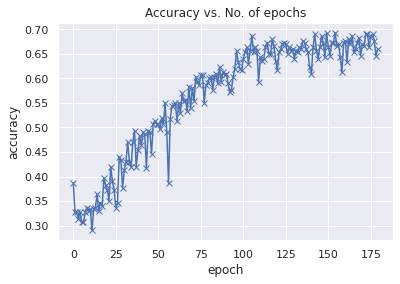

In [34]:
plot_accuracies(history)

In [35]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

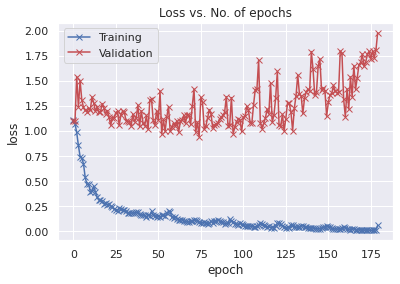

In [36]:
plot_losses(history)

In [37]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

In [38]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: box , Predicted: chevron


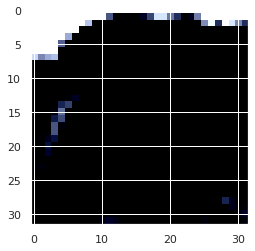

In [39]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

In [40]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.529411792755127, 'val_loss': 2.1469438076019287}